In [2]:
import glob, h5py, math, time, os, json, random, yaml, argparse, datetime
from scipy.stats import norm, expon, chi2, uniform, chisquare
import torch
import pathlib
import corner
import numpy as np
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision.datasets import Imagenette
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
import matplotlib as mpl
#mpl.use('Agg')                                                                                        
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from CLutils import *
from IMAGENETTEutils import *

In [2]:
full_dataset = ImagenetteDataset(patch_size=160)

# simply plot few imags

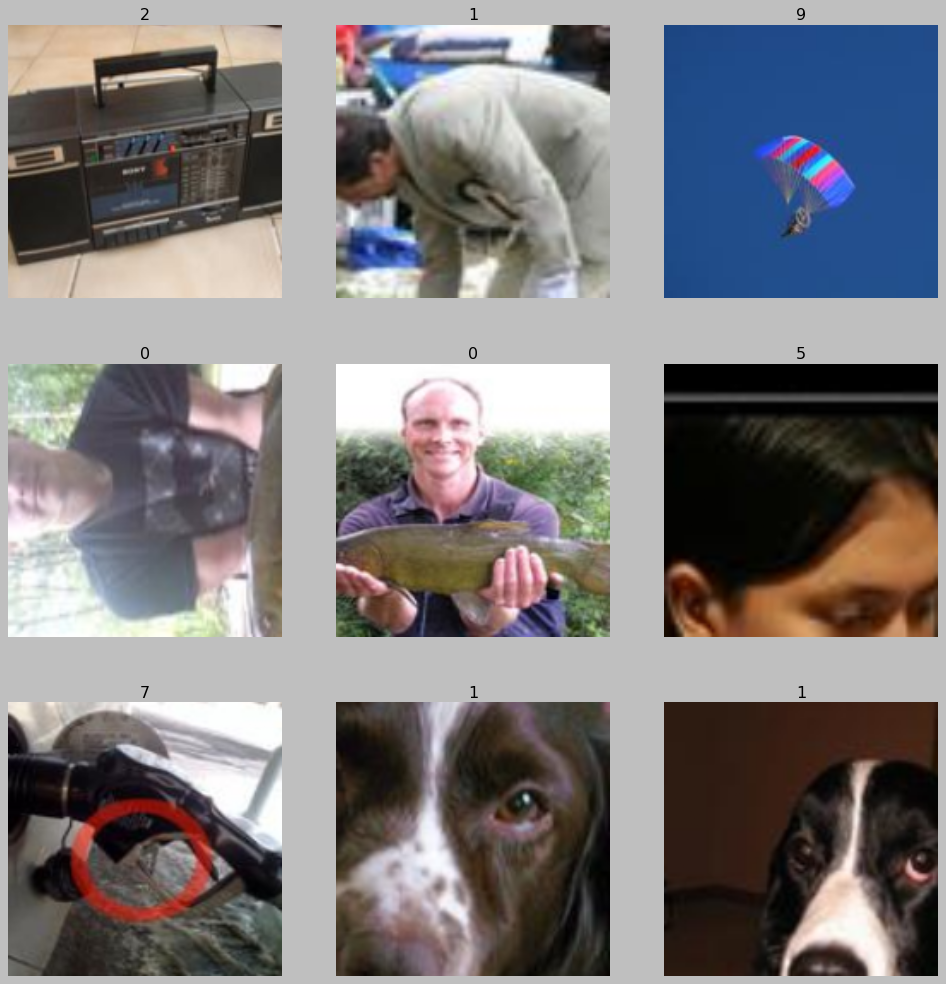

In [5]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
visualize_trainset = ImagenetteDataset(patch_size=160, should_normalize=False)
index = 0
for y in range(3):
    for x in range(3):
        #index = random.randint(0, len(full_dataset) - 1)
        sample = visualize_trainset[index]
        ax[y, x].imshow(sample[0].numpy().transpose(1,2,0))
        ax[y, x].set_axis_off()
        ax[y, x].set_title(str(sample[1]))
        index+=1
plt.show(); 

In [40]:
N_train = 8000
N_val = 1000
train_dataset = Subset(full_dataset, range(N_train))
val_dataset = Subset(full_dataset, range(N_train, N_train+N_val))
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

# model 

In [41]:
# Load a pretrained ResNet50 model
latent_dim = 2
model = models.resnet50(pretrained=True)

# Modify the final layer to fit the number of ImageNet classes (1000 classes)
num_ftrs = model.fc.in_features

# Freeze layers except for the last few layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last few layers for fine-tuning
#for param in model.layer4.parameters():
#    param.requires_grad = True

# Use custom fully connected layers
model.fc = torch.nn.Sequential(
    torch.nn.Linear(num_ftrs, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    #torch.nn.Linear(512, 256),
    #torch.nn.ReLU(),
    #torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(128, latent_dim)  # Adjust for the number of classes
)

/Users/gaiagrosso/jupyter_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gaiagrosso/jupyter_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
temperature=1
criterion = SimCLRLoss(temperature=temperature)#torch.nn.CrossEntropyLoss()#SimCLRLoss(temperature=temperature)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# Initialize the optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Set up a cosine annealing scheduler with warmup steps
scheduler = CosineAnnealingLR(optimizer, T_max=200)

In [52]:
epochs_history = np.array([])
loss_history = np.array([])
val_loss_history = np.array([])

In [92]:
# Training loop
num_epochs = 30
masked_label = 7
for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set model to training mode
    #running_loss = 0.0
    loss_all = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs[labels!=masked_label]
        labels = labels[labels!=masked_label]
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss_all +=loss
        loss.backward()  # Backpropagation
        #running_loss += loss.item()
    optimizer.step()  # Optimization step
    optimizer.zero_grad()  # Zero the parameter gradients
    epoch_train_loss = loss_all.item() / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation during validation
        for data in val_loader:
            inputs, labels = data
            inputs = inputs[labels!=masked_label]
            labels = labels[labels!=masked_label]
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    epoch_val_loss = running_val_loss / len(val_loader)
    val_loss_history = np.append(val_loss_history, epoch_val_loss)
    loss_history = np.append(loss_history, epoch_train_loss)
    epochs_history = np.append(epochs_history, epoch+10)
    print(f'Epoch {epoch+1}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
    if not epoch%10: 
        # Save checkpoint
        torch.save({
            'epoch': len(epochs_history)+10,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            # Add any other relevant information
            }, 'checkpoint_%i.pth'%(len(epochs_history)+10))

Epoch 1, Training Loss: 1.3920, Validation Loss: 1.1743
Epoch 2, Training Loss: 1.3981, Validation Loss: 1.1588
Epoch 3, Training Loss: 1.4022, Validation Loss: 1.1642
Epoch 4, Training Loss: 1.3972, Validation Loss: 1.1790
Epoch 5, Training Loss: 1.3818, Validation Loss: 1.1545
Epoch 6, Training Loss: 1.3917, Validation Loss: 1.1558
Epoch 7, Training Loss: 1.3819, Validation Loss: 1.1819
Epoch 8, Training Loss: 1.3847, Validation Loss: 1.1815
Epoch 9, Training Loss: 1.4033, Validation Loss: 1.1421
Epoch 10, Training Loss: 1.3848, Validation Loss: 1.1346
Epoch 11, Training Loss: 1.3668, Validation Loss: 1.1443
Epoch 12, Training Loss: 1.3741, Validation Loss: 1.1526
Epoch 13, Training Loss: 1.3876, Validation Loss: 1.1718
Epoch 14, Training Loss: 1.3765, Validation Loss: 1.1589
Epoch 15, Training Loss: 1.3804, Validation Loss: 1.1759
Epoch 16, Training Loss: 1.3683, Validation Loss: 1.1659
Epoch 17, Training Loss: 1.3876, Validation Loss: 1.1860
Epoch 18, Training Loss: 1.3758, Validat

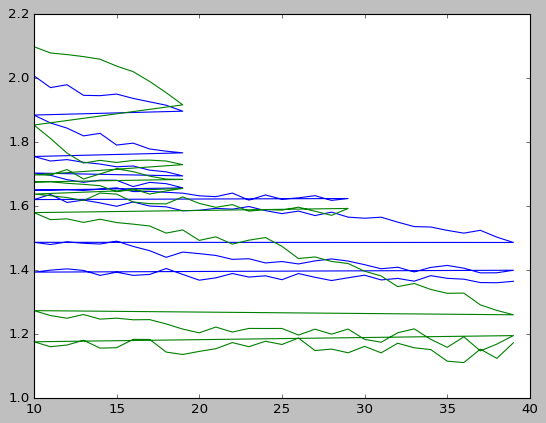

In [94]:
plt.plot(epochs_history, loss_history)
plt.plot(epochs_history, val_loss_history)
plt.show()

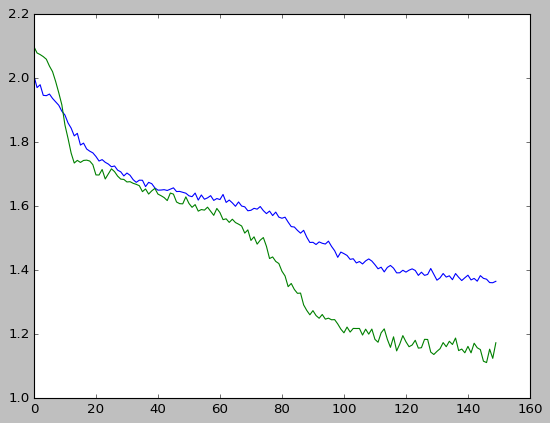

In [97]:
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.show()

In [87]:
# Save checkpoint
torch.save({
            'epoch': len(epochs_history)+10,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            # Add any other relevant information
            }, 'checkpoint.pth')

In [62]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)
class_names = list(lbl_dict.values())
print(class_names)

['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']


In [95]:
# Combine data and create labels
data, labels = [],[]
with torch.no_grad():  # Disable gradient calculation during validation
    for data_b in val_loader:
        inputs_b, labels_b = data_b
        outputs_b = model(inputs_b)
        data.append(outputs_b.detach().numpy())
        labels.append(labels_b.detach().numpy())
data = np.vstack(data)
labels = np.array(labels).reshape((-1,))
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
print(np.unique(labels))

[0 1 2 3 4 5 6 7 8 9]


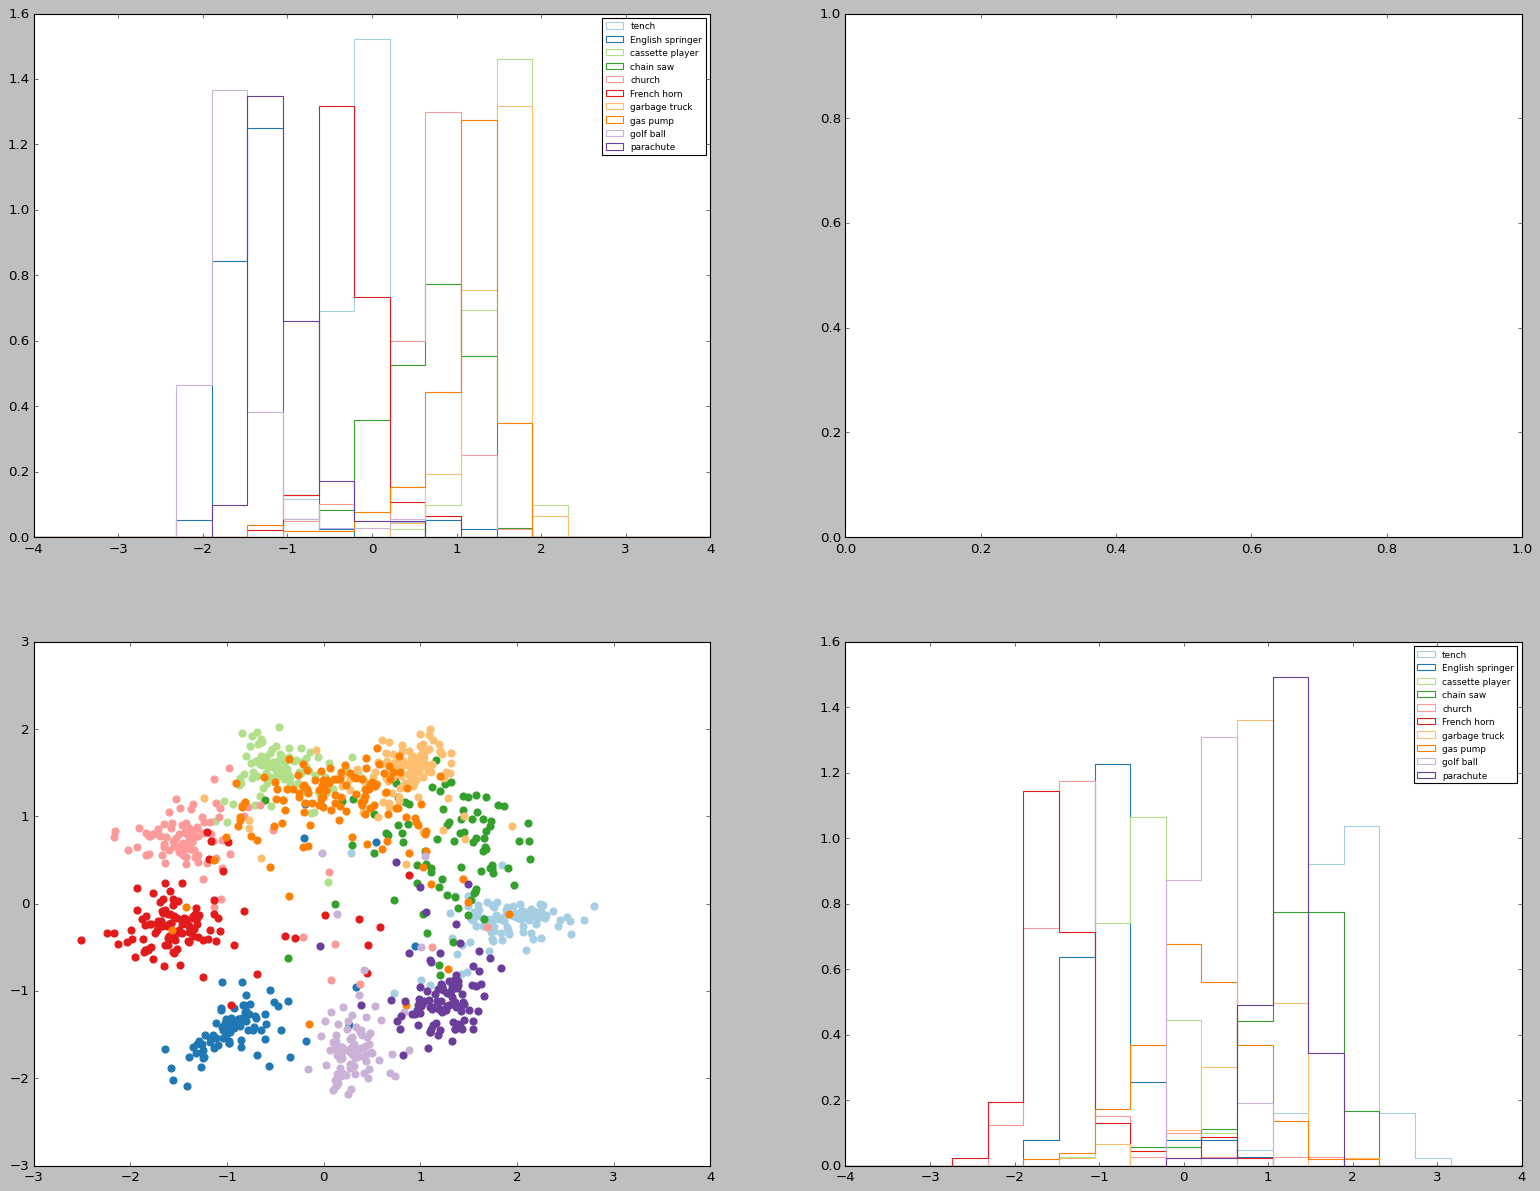

In [96]:
# Create the corner plot
'''
figure = corner.corner(
    data,
    labels=['x', 'y'],
    truths=None,
    color='black',
    hist_kwargs={'density': True},
    label_kwargs={'fontsize': 12}
)
'''
figure, axes = plt.subplots(nrows=latent_dim, ncols=latent_dim, figsize=(24, 18))
fig.patch.set_facecolor('white')
# Overlay histograms for each class
index = -1
bins=np.linspace(-4, 4, 20)
for i in range(data.shape[1]):
    for j in range(data.shape[1]):
        index +=1
        ax = figure.axes[index]
        for k, class_name in enumerate(class_names):
                class_data = data[labels == k]
                if j==i:
                    h=ax.hist(class_data[:, j],bins=bins, histtype='step', color=colors[k], density=True, label=class_name)
                    bins=h[1]
                    ax.legend(fontsize=8)
                elif j<i:
                    ax.scatter(class_data[:, i], class_data[:, j], color=colors[k], s=40)#, label=class_names[i])

# Show the plot
plt.show()